# ResNet 구현 및 Ablation Study

ablation study? 제안한 방법의 유효함을 증명하기 위해서 제안 기술을 제거, 추가 후 성능을 비교

- Cats&Dogs 데이터셋을 사용해 Ablation Study를 진행하자!

## 1.  Cats&Dogs 데이터 준비하기

tf.dataset 활용

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa #

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model #모델 시각화
import pickle

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


#### tf.dataset의 경우 numpy가 아니기 때문에 별도의 함수를 통해서 확인한다.

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
ds_info.features["label"].num_classes

2

In [7]:
ds_info.features["label"].names

['cat', 'dog']

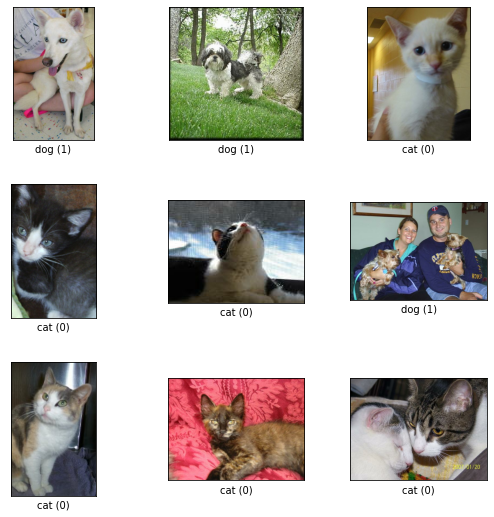

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

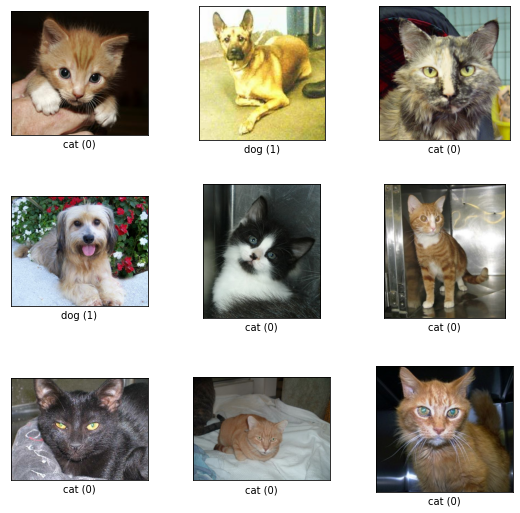

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

___

## 2. ResNet 구현하기

ResNet 구조 확인

- ResNet 34, 50을 구현한다.

![image](https://user-images.githubusercontent.com/86637320/134626354-0cbd596c-28f2-4634-a1d9-b7722b187d78.png)

___

### Conv 블록 만들기

- CNN - BN - Activation

In [10]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1,
                    unit_num=1,
                    block_num=1,
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}')(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [11]:
conv_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
conv_block_output = build_conv_block(conv_input_layer)    # VGG 블록 생성

#### Conv 블록 확인

In [12]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=conv_input_layer, outputs=conv_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 32, 32, 64)        1792      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 32, 32, 64)        256       
_________________________________________________________________
stage1_1_relu1 (Activation)  (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_________________________________________________________________


### Residual 블록 만들기

In [13]:
# function for building Conv Block

def build_residual_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0: 
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=1, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                short_cut = keras.layers.Conv2D(filters=channel, kernel_size=1, strides=2, 
                                                name=f'stage{stage_num}_{unit_num}_shortcut{unit}')(x)
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                short_cut = x
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Add()([x, short_cut])
            x = keras.layers.Activation('relu')(x)
            
    return x

In [14]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              activation = 'softmax',
              is_50 = True,
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_residual_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

#### ResNet50

In [15]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_50 = build_resnet(is_50=True,num_classes = 10,name="ResNet50")

resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_relu1 (Activation)     (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
___________________________________________________________________________________________

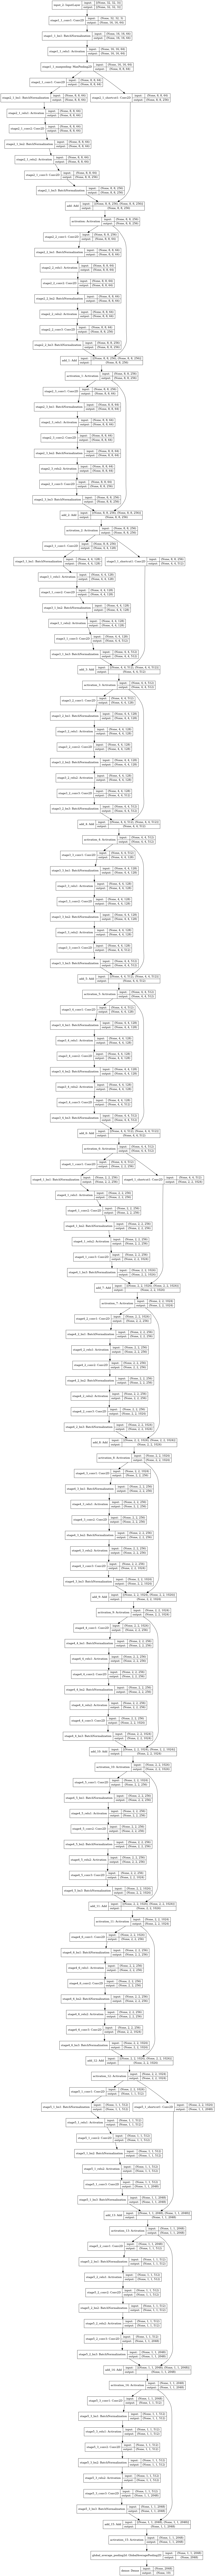

In [16]:
plot_model(resnet_50, show_shapes=True)

#### ResNet34

In [17]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
resnet_34 = build_resnet(is_50=False,num_classes = 10,name="ResNet34")

resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
stage1_1_relu1 (Activation)     (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
___________________________________________________________________________________________

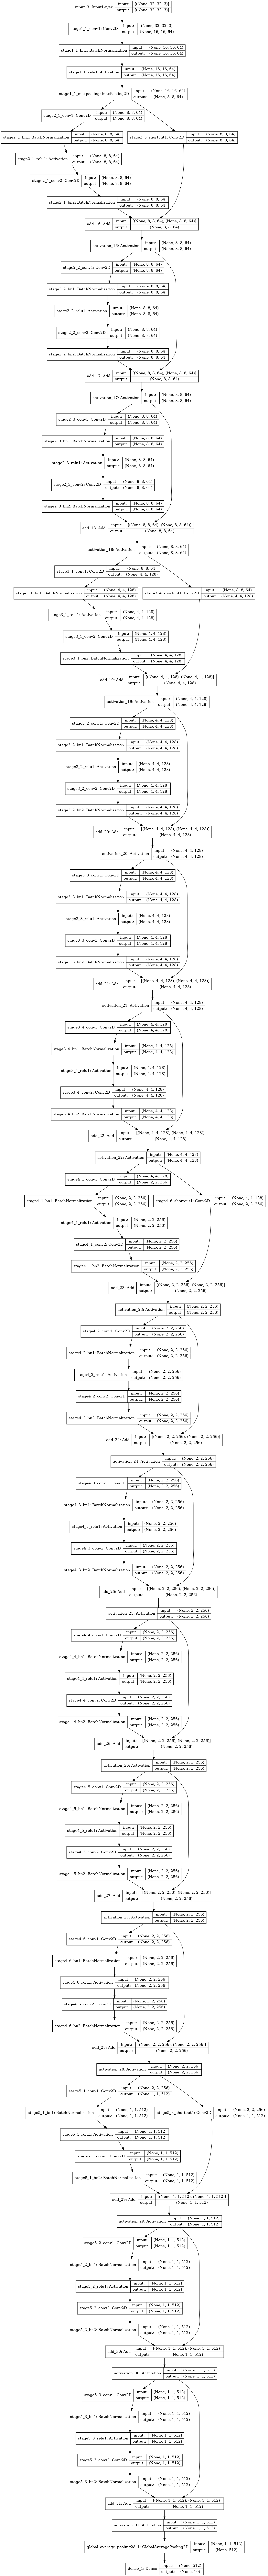

In [18]:
plot_model(resnet_34, show_shapes=True)

___

### Plain ResNet

In [19]:
# function for building Conv Block

def build_conv_block(input_layer,
                    channel=64,
                    kernel_size = 3,
                    strides = 1,
                    stage_num=1,
                    unit_num=1,
                    block_num=1,
                    activation='relu'
                   ):
    # 입력 레이어
    x = input_layer
    
    
    # CNN 레이어
    x = keras.layers.Conv2D(filters=channel,kernel_size = kernel_size, strides=strides ,padding='same',
                            name=f'stage{stage_num}_{unit_num}_conv{block_num}')(x)    

    # Batch Normal 레이어
    x = keras.layers.BatchNormalization(name = f'stage{stage_num}_{unit_num}_bn{block_num}')(x)
    
    #activation 레이어
    if activation :
        x = keras.layers.Activation(activation = activation, name = f'stage{stage_num}_{unit_num}_relu{block_num}')(x)

    return x

In [20]:
# function for building Conv Block

def build_plain_block(input_layer,
                    channel=64,
                    stage_num=1,
                    unit_num=1,
                    is_50 = True,
                    is_first = 0):
    # 입력 레이어
    x = input_layer
    
    #ResNet 50
    if is_50 :
        for unit in range(1,unit_num+1):
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                        
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel*4, kernel_size=1, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=3, activation=None)
                
            x = keras.layers.Activation('relu')(x)
    
    #ResNet 34
    else :
        for unit in range(1,unit_num+1):
            
            if unit == 1 and is_first == 0: 
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            elif unit == 1 : # 첫번째 유닛 : strides 2로 feature_map 크기 줄임
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=2, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
            else :
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=1, activation='relu')
                x = build_conv_block(input_layer=x, channel=channel, kernel_size=3, strides=1, stage_num=stage_num, unit_num=unit,
                                    block_num=2, activation=None)
                
            x = keras.layers.Activation('relu')(x)
            
    return x

In [21]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_plain_resnet(input_shape=(32,32,3),
              unit_num_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50 = True,
              activation = 'softmax',
              name = 'ResNet50'):
    
    assert len(unit_num_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    x = build_conv_block(input_layer=input_layer,channel=64,kernel_size=7,strides=2)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same',name = 'stage1_1_maxpooling')(x)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (unit_num, channel) in enumerate(zip(unit_num_list, channel_list)):
        
        stage = i+2
        x = build_plain_block(x,channel,stage,unit_num,is_50,i) 
        
    x = keras.layers.GlobalAvgPool2D()(x)
    output = keras.layers.Dense(units=num_classes, activation=activation)(x)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
        name=name
    )
    return model

#### Plain Resnet 50

In [22]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_50 = build_plain_resnet(is_50=True,num_classes = 10,name="Plain-ResNet50")

plain_resnet_50.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_relu1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)       

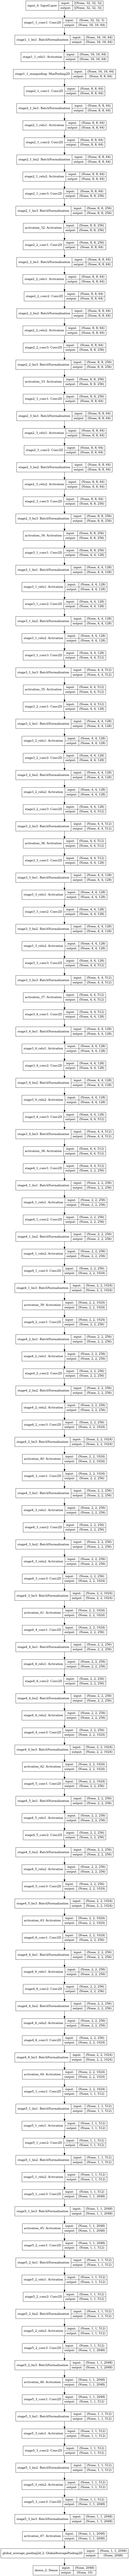

In [23]:
plot_model(plain_resnet_50, show_shapes=True)

#### Plain Resnet 34

In [24]:
# 기본값을 그대로 사용해서 ResNet50 모델을 만들면 ResNet50이 됩니다.
plain_resnet_34 = build_plain_resnet(is_50=False,num_classes = 10,name="Plain-ResNet50")

plain_resnet_34.summary()

Model: "Plain-ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 16, 16, 64)        9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 16, 16, 64)        256       
_________________________________________________________________
stage1_1_relu1 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_1_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)       

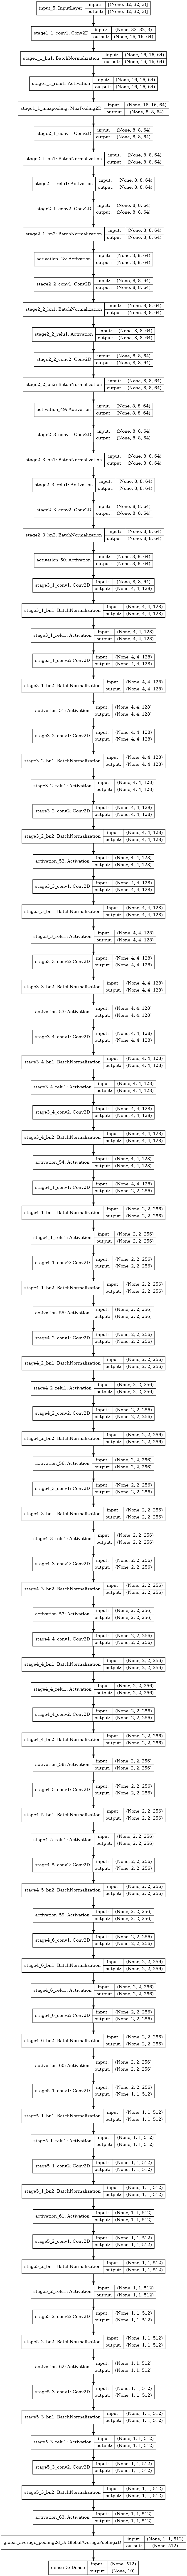

In [25]:
plot_model(plain_resnet_34, show_shapes=True)

___

## 3. 모델 학습하기

#### Plain, Residual 효과 비교

In [26]:
BATCH_SIZE = 32
EPOCH = 20

In [27]:
def normalize_and_resize_img(image, label): #map에 사용될 함수
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [28]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1 #interleaving
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE) #normalization 진행
ds_test = apply_normalize_on_dataset(ds_test,is_test=True, batch_size=BATCH_SIZE)

#### 학습 환경 설정

- 너무 느려서 포기

In [30]:
resnet_50 = build_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="ResNet50")
resnet_34 = build_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="ResNet34")
plain_resnet_50 = build_plain_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="Plain-ResNet50")
plain_resnet_34 = build_plain_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="Plain-ResNet34")

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1),
    metrics=['accuracy'],
)

#### Adam

In [31]:
resnet_50 = build_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="ResNet50")
resnet_34 = build_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="ResNet34")
plain_resnet_50 = build_plain_resnet(input_shape=(224,224,3),is_50=True,num_classes = 1,activation='sigmoid',name="Plain-ResNet50")
plain_resnet_34 = build_plain_resnet(input_shape=(224,224,3),is_50=False,num_classes = 1,activation='sigmoid',name="Plain-ResNet34")

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

plain_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

plain_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

#### 학습

In [32]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 459s 732ms/step - loss: 0.9764 - accuracy: 0.5876 - val_loss: 1.3655 - val_accuracy: 0.5319
Epoch 2/20
581/581 [==============================] - 407s 700ms/step - loss: 0.6157 - accuracy: 0.6692 - val_loss: 0.6799 - val_accuracy: 0.6144
Epoch 3/20
581/581 [==============================] - 407s 700ms/step - loss: 0.5570 - accuracy: 0.7226 - val_loss: 0.8934 - val_accuracy: 0.6060
Epoch 4/20
581/581 [==============================] - 407s 701ms/step - loss: 0.5140 - accuracy: 0.7487 - val_loss: 0.7136 - val_accuracy: 0.6944
Epoch 5/20
581/581 [==============================] - 406s 699ms/step - loss: 0.4573 - accuracy: 0.7934 - val_loss: 0.6163 - val_accuracy: 0.7437
Epoch 6/20
581/581 [==============================] - 406s 699ms/step - loss: 0.4139 - accuracy: 0.8146 - val_loss: 0.8213 - val_accuracy: 0.6668
Epoch 7/20
581/581 [==============================] - 406s 700ms/step - loss: 0.3532 - accuracy: 0.8449 - val_loss: 0.7275 -

In [33]:
with open('/aiffel/aiffel/history_50', 'wb') as file_pi:
    pickle.dump(history_50.history, file_pi)

In [34]:
history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 258s 420ms/step - loss: 0.9137 - accuracy: 0.5878 - val_loss: 0.7102 - val_accuracy: 0.5808
Epoch 2/20
581/581 [==============================] - 237s 409ms/step - loss: 0.5838 - accuracy: 0.6952 - val_loss: 1.4254 - val_accuracy: 0.5181
Epoch 3/20
581/581 [==============================] - 238s 410ms/step - loss: 0.5093 - accuracy: 0.7546 - val_loss: 0.9133 - val_accuracy: 0.6233
Epoch 4/20
581/581 [==============================] - 238s 409ms/step - loss: 0.4423 - accuracy: 0.7991 - val_loss: 1.1855 - val_accuracy: 0.5970
Epoch 5/20
581/581 [==============================] - 238s 410ms/step - loss: 0.3784 - accuracy: 0.8374 - val_loss: 1.0138 - val_accuracy: 0.6000
Epoch 6/20
581/581 [==============================] - 238s 409ms/step - loss: 0.3208 - accuracy: 0.8622 - val_loss: 0.4955 - val_accuracy: 0.7713
Epoch 7/20
581/581 [==============================] - 238s 410ms/step - loss: 0.2718 - accuracy: 0.8889 - val_loss: 0.3752 -

In [35]:
with open('/aiffel/aiffel/history_34', 'wb') as file_pi:
    pickle.dump(history_34.history, file_pi)

In [36]:
history_50_plain = plain_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 362s 608ms/step - loss: 0.7263 - accuracy: 0.5529 - val_loss: 0.8021 - val_accuracy: 0.5099
Epoch 2/20
581/581 [==============================] - 352s 606ms/step - loss: 0.6869 - accuracy: 0.5512 - val_loss: 0.8170 - val_accuracy: 0.5399
Epoch 3/20
581/581 [==============================] - 352s 606ms/step - loss: 0.6667 - accuracy: 0.5985 - val_loss: 1.3528 - val_accuracy: 0.5539
Epoch 4/20
581/581 [==============================] - 353s 607ms/step - loss: 0.6558 - accuracy: 0.6177 - val_loss: 0.9828 - val_accuracy: 0.5144
Epoch 5/20
581/581 [==============================] - 352s 606ms/step - loss: 0.6933 - accuracy: 0.5358 - val_loss: 0.8114 - val_accuracy: 0.5101
Epoch 6/20
581/581 [==============================] - 352s 605ms/step - loss: 0.6824 - accuracy: 0.5621 - val_loss: 0.7175 - val_accuracy: 0.5284
Epoch 7/20
581/581 [==============================] - 352s 605ms/step - loss: 0.6604 - accuracy: 0.6055 - val_loss: 0.7242 -

In [37]:
with open('/aiffel/aiffel/history_50_plain', 'wb') as file_pi:
    pickle.dump(history_50_plain.history, file_pi)

In [38]:
history_34_plain = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
581/581 [==============================] - 235s 391ms/step - loss: 0.7414 - accuracy: 0.5349 - val_loss: 0.6976 - val_accuracy: 0.5435
Epoch 2/20
581/581 [==============================] - 227s 390ms/step - loss: 0.6801 - accuracy: 0.5477 - val_loss: 0.6838 - val_accuracy: 0.5601
Epoch 3/20
581/581 [==============================] - 227s 390ms/step - loss: 0.6657 - accuracy: 0.5745 - val_loss: 0.7022 - val_accuracy: 0.5338
Epoch 4/20
581/581 [==============================] - 227s 390ms/step - loss: 0.6624 - accuracy: 0.5933 - val_loss: 0.6956 - val_accuracy: 0.5631
Epoch 5/20
581/581 [==============================] - 227s 391ms/step - loss: 0.6461 - accuracy: 0.6161 - val_loss: 0.6901 - val_accuracy: 0.5058
Epoch 6/20
581/581 [==============================] - 227s 391ms/step - loss: 0.6400 - accuracy: 0.6286 - val_loss: 0.7028 - val_accuracy: 0.4953
Epoch 7/20
581/581 [==============================] - 227s 391ms/step - loss: 0.6095 - accuracy: 0.6643 - val_loss: 0.8334 -

In [39]:
with open('/aiffel/aiffel/history_34_plain', 'wb') as file_pi:
    pickle.dump(history_34_plain.history, file_pi)

### 결과 시각화

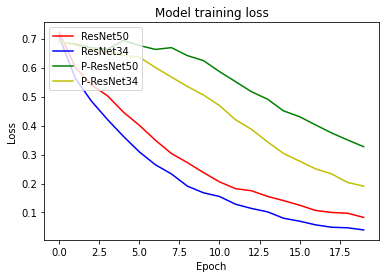

In [40]:
import matplotlib.pyplot as plt

plt.plot(history_50.history['loss'], 'r')
plt.plot(history_34.history['loss'], 'b')
plt.plot(history_50_plain.history['loss'], 'g')
plt.plot(history_34_plain.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'ResNet34','P-ResNet50','P-ResNet34'], loc='upper left')
plt.show()

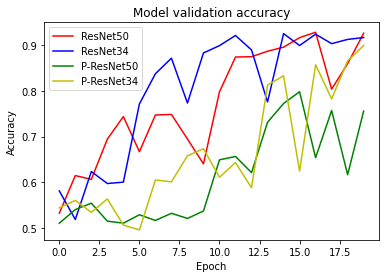

In [41]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50_plain.history['val_accuracy'], 'g')
plt.plot(history_34_plain.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50', 'ResNet34','P-ResNet50','P-ResNet34'], loc='upper left')
plt.show()

___

#### Validation accuracy 비교

In [50]:
val_accuracy_50 = np.array(history_50.history['val_accuracy'])
val_accuracy_34 = np.array(history_34.history['val_accuracy'])
val_accuracy_50_plain = np.array(history_50_plain.history['val_accuracy'])
val_accuracy_34_plain = np.array(history_34_plain.history['val_accuracy'])

print(val_accuracy_50.mean(),val_accuracy_34.mean(),val_accuracy_50_plain.mean(),val_accuracy_34_plain.mean())

0.7726831942796707 0.8013254314661026 0.6136206954717636 0.6627370685338974


|네트워크|Residual|Plain|
|------|---|---|
|34Layer|0.80|0.66|
|50Layer|0.77|0.61|


- Residual block의 사용으로 깊은 레이어에서도 학습이 잘 이뤄짐을 확인할 수 있었다.

#### Pickle load! 

- 다음엔 .pickle 확장자를 넣어서 저장해야겠다.

In [53]:
history_test = pickle.load(open('/aiffel/aiffel/history_50',"rb"))

In [55]:
history_test

{'loss': [0.7219175696372986,
  0.6008864045143127,
  0.5410067439079285,
  0.5030418038368225,
  0.4464246332645416,
  0.4007420539855957,
  0.3495003581047058,
  0.30341026186943054,
  0.2720911204814911,
  0.2377939671278,
  0.20576211810112,
  0.1823042631149292,
  0.1749795824289322,
  0.1556147336959839,
  0.1408979594707489,
  0.1251869946718216,
  0.10698717832565308,
  0.10011985898017883,
  0.09745145589113235,
  0.08297664672136307],
 'accuracy': [0.6181504726409912,
  0.6801850199699402,
  0.7338396906852722,
  0.7581755518913269,
  0.7977177500724792,
  0.8208898901939392,
  0.8490749001502991,
  0.8712561726570129,
  0.8866939544677734,
  0.9025925397872925,
  0.9150069952011108,
  0.9258800745010376,
  0.9256647825241089,
  0.9351432919502258,
  0.9433627128601074,
  0.95020991563797,
  0.95713210105896,
  0.9617539048194885,
  0.9613768458366394,
  0.9685649871826172],
 'val_loss': [1.365471601486206,
  0.6799474954605103,
  0.8933879733085632,
  0.7135712504386902,
  0

___

# 정리

**Residual block**에 대한 **Ablation Study**를 진행해보았다. 이를 위해서 ResNet50, 34을 residual block이 있는 버전과 plain 버전으로 나눠서 구현했다. VGG넷은 네트워크 구조가 간단하여 구현하는데 별 어려움이 없었지만 ResNet의 경우 모듈화해서 구하려고 하니 자꾸 헷갈려서 시간이 꽤 오래 걸렸다. Activation, num_class를 처음 구현할 때는 입력 변수로 설정하지 않았어서 다시 함수를 변경하는 등 어려움이 많았다. 훈련에 사용될 **Optimizer**도 Resnet 논문에 명시된 SGD로 사용했다. 하지만 학습 시간이 너무 오래 걸리는 거 같아 도중에 Adam으로 변경했다. **BATCH SIZE**를 메모리 부족 때문에 256으로 설정하지 못하고 32로 설정했다. 